<a href="https://colab.research.google.com/github/abhishekY2401/Sales_Forecasting_Model/blob/main/CLIMATE_CHANGE_FORECASTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from pdpbox.pdp import pdp_isolate, pdp_plot

In [85]:
globalTemp = pd.read_csv("/content/GlobalTemperatures.csv")

In [86]:
globalTemp.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
globalTemp.shape

(3192, 9)

In [89]:
print(globalTemp.isnull().sum())

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64


In [90]:
globalTemp.columns

Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')

In [92]:
# making a copy of dataframe so that original is not affected.
df = globalTemp.copy()

# drop columns of high cardinality to avoid data leakage
globalTemp = globalTemp.drop(columns=['LandAverageTemperatureUncertainty', 'LandMaxTemperatureUncertainty', 'LandMinTemperatureUncertainty', 'LandAndOceanAverageTemperatureUncertainty'], axis=1)


In [93]:
globalTemp.columns

Index(['dt', 'LandAverageTemperature', 'LandMaxTemperature',
       'LandMinTemperature', 'LandAndOceanAverageTemperature'],
      dtype='object')

In [94]:
# convert dt column to datetime
globalTemp['dt'] = pd.to_datetime(df['dt'])
globalTemp['Month'] = globalTemp['dt'].dt.month
globalTemp['Year'] = globalTemp['dt'].dt.year

globalTemp = globalTemp.drop('dt', axis=1)
globalTemp = globalTemp.drop('Month', axis=1)
globalTemp = globalTemp[globalTemp.Year >= 1850]

# set index to Year column
globalTemp = globalTemp.set_index(['Year'])

# drop na values
globalTemp.dropna()

,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature
Year,,,,
1850,0.749,8.242,-3.206,12.833
1850,3.071,9.970,-2.291,13.588
1850,4.954,10.347,-1.905,14.043
1850,7.217,12.934,1.018,14.667
1850,10.004,15.655,3.811,15.507
...,...,...,...,...
2015,14.755,20.699,9.005,17.589
2015,12.999,18.845,7.199,17.049
2015,10.801,16.450,5.232,16.290


In [95]:
globalTemp.shape

(1992, 4)

In [96]:
globalTemp.isnull().sum()

LandAverageTemperature            0
LandMaxTemperature                0
LandMinTemperature                0
LandAndOceanAverageTemperature    0
dtype: int64

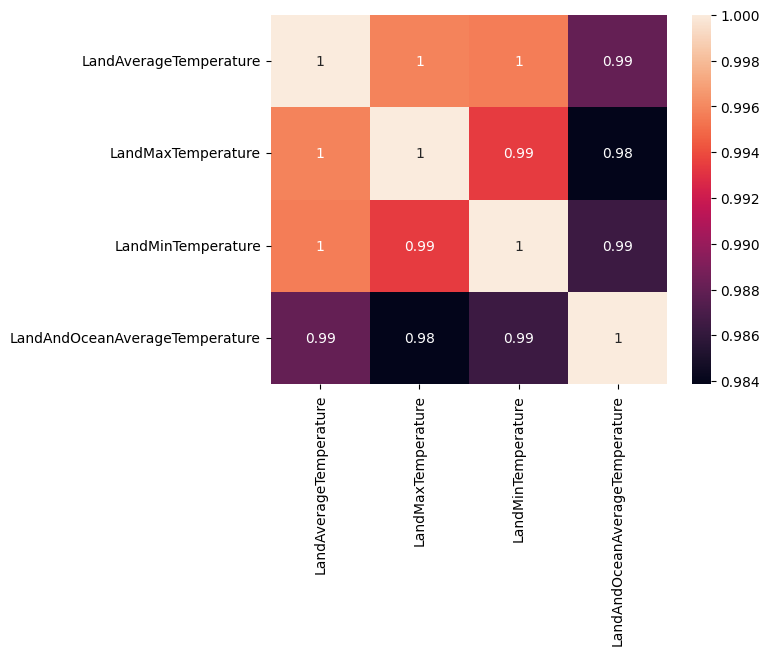

In [97]:
# visualizing the correlation between different attributes

corrMatrix = globalTemp.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [98]:
# target feature
target = 'LandAndOceanAverageTemperature'
Y = globalTemp[target]

# feature matrix
X = globalTemp[["LandAverageTemperature", "LandMaxTemperature", "LandMinTemperature"]]


In [99]:
# Train and Test our X features & Y target
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5, random_state=42)

In [100]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(996, 3)
(996, 3)
(996,)
(996,)


In [101]:
y_pred = [Y_train.mean()] * len(Y_train)

print("Baseline MAE: ", round(mean_absolute_error(Y_train, y_pred), 5))

Baseline MAE:  1.14746


In [102]:
lm = make_pipeline(
    StandardScaler(),
    LinearRegression(),
)
lm.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [103]:
forestModel = make_pipeline(
    SelectKBest(k="all"),
    StandardScaler(),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=77,
        n_jobs=-1
    )
)

forestModel.fit(X_train, Y_train)

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, n_jobs=-1,
                                       random_state=77))])

In [104]:
print("Linear Regression Training MAE: ", round(mean_absolute_error(Y_train, lm.predict(X_train))), 5)
print("Linear Regression Test MAE: ", round(mean_absolute_error(Y_val, lm.predict(X_val))), 5)


Linear Regression Training MAE:  0 5
Linear Regression Test MAE:  0 5


In [105]:
print("Random Forest Regressor Training MAE: ", round(mean_absolute_error(Y_train, forestModel.predict(X_train))))
print("Random Forest Regressor Test MAE: ", round(mean_absolute_error(Y_val, forestModel.predict(X_val))))


Random Forest Regressor Training MAE:  0
Random Forest Regressor Test MAE:  0


In [107]:
y_pred = lm.predict(X_val)

In [108]:
errors = abs(y_pred - Y_val)
# calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_train)

# calculate and display accuracy
accuracy = 100 - np.mean(mape)
print("Linear Regression Model Prediction Accuracy: ", round(accuracy, 2), "%.")

Linear Regression Model Prediction Accuracy:  98.97 %.


In [109]:
errors = abs(y_pred - Y_val)
mape = 100 * (errors/Y_train)

accuracy = 100 - np.mean(mape)
print("Random Forest Regressor Model Prediction Accuracy: ", round(accuracy, 2), "%.")

Random Forest Regressor Model Prediction Accuracy:  98.97 %.


(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <Axes: >, 'pdp_ax': <Axes: xlabel='LandAverageTemperature'>})

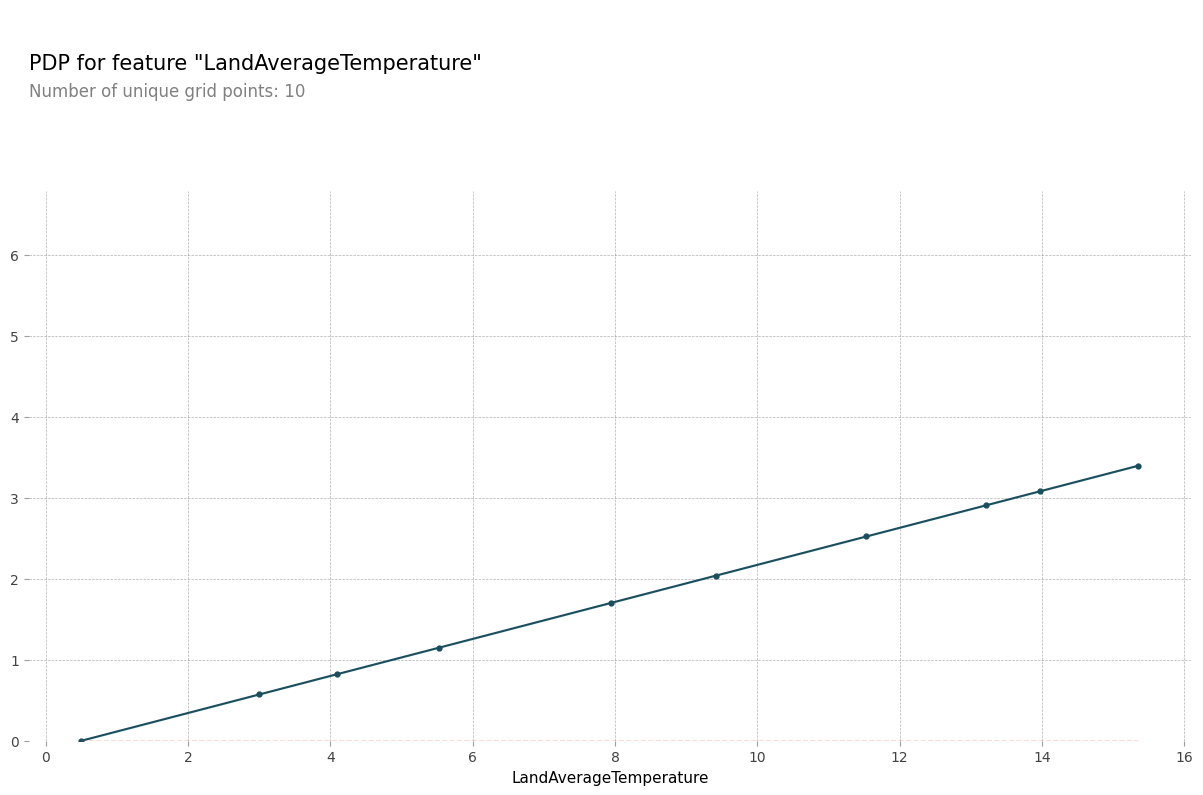

In [125]:
feature = 'LandAverageTemperature'

isolated = pdp_isolate(
    model = lm, 
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature)

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <Axes: >, 'pdp_ax': <Axes: xlabel='LandAverageTemperature'>})

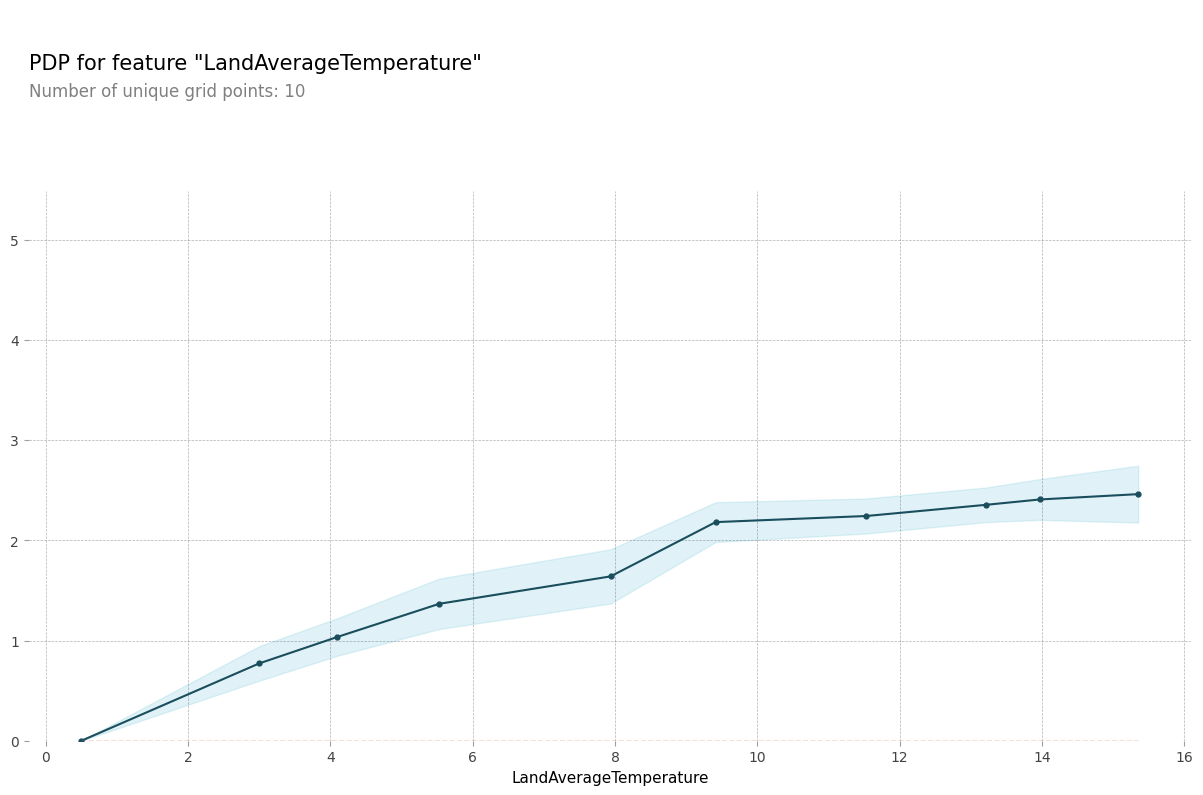

In [126]:
feature = 'LandAverageTemperature'

isolated = pdp_isolate(
    model = forestModel, 
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature)